## Klassifikation der einzelnen Objecte im mvtec_anomaly_detection Dataset 

### Importieren der Bibliotheken und Files 

In [24]:
from read_and_label_Images_only_objects import read_and_label_Images_only_objects
from read_and_label_Images import read_and_label_Images
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import backend as K

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Einlesen des Datensatzes und in neuer Ordnerstruktur abspeichern

In [16]:
src_path="orginal_Dataset/mvtec_anomaly_detection/" #Angabe des Pfades zum Unveränderten Datensatz 
dst_path="Set_01/" #Ablageort des neuen Datensatzes 


if not os.path.exists(dst_path): #Nur erstellen, wenn noch nicht vorhanden 
    read_and_label_Images_only_objects(src_path,dst_path) # Daten sind nur noach Objekt sortiert keine Sortierung nach gut und schlecht 


### Aufteilen der Daten in Trainings und Validierungsdaten 

In [17]:
# returns a tf.data.Dataset Object
training_set = image_dataset_from_directory(dst_path,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             batch_size=32,
                                             image_size=(150, 150),
                                             seed=1337,
                                             label_mode = 'categorical')

val_dataset = image_dataset_from_directory(dst_path,
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  batch_size=32,
                                                  image_size=(150, 150),
                                                  seed=1337,
                                                  label_mode = 'categorical')

Found 5354 files belonging to 15 classes.
Using 4284 files for training.
Found 5354 files belonging to 15 classes.
Using 1070 files for validation.


### Erstellen eigener Metrics 

In [25]:


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Erzeugen eines Data Augemnatation Layer mit Keras 

In [26]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

### Laden des vortrainierten Netzes (ResNetV2)

In [27]:
base_model = keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)

## Erstellen und Trainieren des KI Modells

Input-Layer wird für unsere Bilder angepasst <br>
Danach kommt ein Data-Augmentation-Layer und Layer zum anpassen der Bilder<br>
Das Basis-Modell wird angefügt und die letzten Layer inklusive Output-Layer wird für unsere Ergebnisse angepasst


In [31]:
base_model.trainable = False



inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs) 
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)
#x = tf.keras.applications.InceptionResNetV2.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense(15,activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [33]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy',f1_m,precision_m, recall_m])

history = model.fit(training_set, epochs=2, validation_data=val_dataset)


Epoch 1/2
134/134 [==============================] - 186s 1s/step - loss: 0.0527 - accuracy: 0.9986 - f1_m: 0.9836 - precision_m: 0.9986 - recall_m: 0.9697 - val_loss: 0.0474 - val_accuracy: 0.9963 - val_f1_m: 0.9935 - val_precision_m: 0.9963 - val_recall_m: 0.9908
Epoch 2/2
134/134 [==============================] - 216s 2s/step - loss: 0.0262 - accuracy: 0.9993 - f1_m: 0.9938 - precision_m: 0.9993 - recall_m: 0.9886 - val_loss: 0.0247 - val_accuracy: 0.9991 - val_f1_m: 0.9981 - val_precision_m: 0.9991 - val_recall_m: 0.9972


### Modell abspeichern

In [42]:
#TODO Modell Laden geht nicht Unable to restore custom object of type _tf_keras_metric.
# model.save("Models/A1_TL_Objects")
# loaded_model=keras.models.load_model("Models/A1_TL_Objects")

### Anzeigen der Metrics 

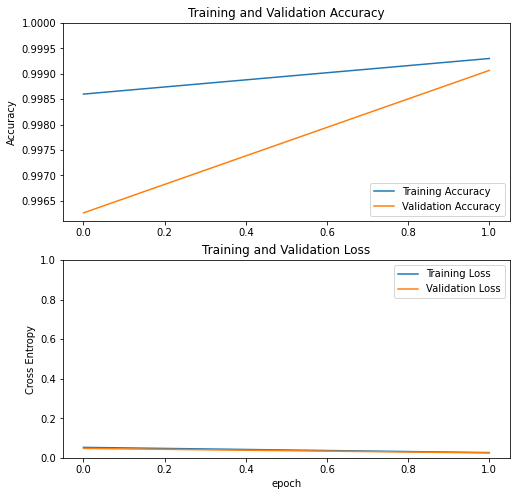

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Traineren des Modells: Fine-Tuning
Nun wird eingestellt, dass auch die Gewichte des Basis-Modells trainiert werden können. Jedoch nur mit geringer Lernrate

In [46]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy',f1_m,precision_m, recall_m]
)

history = model.fit(training_set, epochs=1, validation_data=val_dataset)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0   

### Anzeigen der Metrics 

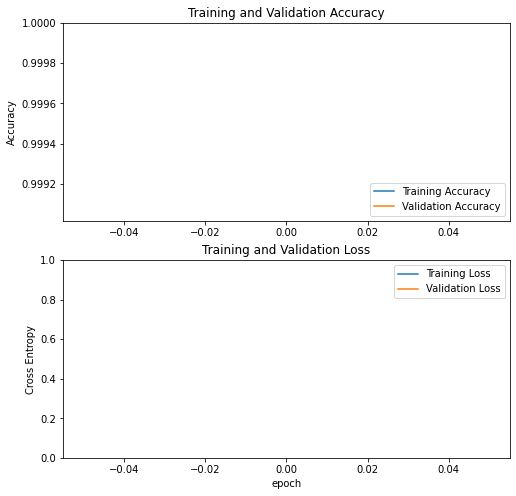

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Abspeichern des Trainierten Modells 

In [54]:
model.save('Models/A1_TL_OO.h5')
loaded_model=keras.models.load_model('Models/A1_TL_OO.h5',custom_objects={"f1_m":f1_m,"precision_m":precision_m,"recall_m":recall_m})

### Bestimmen der Klasse mit dem Trainierten Modell 

In [56]:
import cv2
import numpy as np
def load(filename):
   np_image = cv2.imread(filename)
   np_image = cv2.resize(np_image, (150, 150))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('weiss.JPG')
#0: Dosenoeffner   1:Flaschenoeffner   2:Korkenzieher
model.predict(image)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [70]:
image=val_dataset.get_single_element()
val_dataset.sample_from_datasets


InvalidArgumentError: Dataset had more than one element. [Op:DatasetToSingleElement]